<a href="https://colab.research.google.com/github/urmipandya123/EUI_Predictions/blob/main/EUI_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit_learn==1.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [6]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


# from sklearn.base import BaseEstimator, TransformerMixin
# 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



import optuna


import tqdm
import joblib
import pickle
# serializd your object and svaes its binary form 

import shap


pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')
# blue, orange, green

import warnings
warnings.filterwarnings('ignore')

# <span style="font-family:cursive;text-align:center">⬇️ Import Data</span>

In [7]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('x_test.csv')

In [8]:
df_train = train.copy()
df_test = test.copy()

In [9]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [10]:
train

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36         50.500000   
1                    45.0        1.8                36         50.500000   
2                    97.0        1.8                36         50.500000   
3                    46.0        1.8                36         50.500000   
4                   100.0        2.4                36         50.500000   
...                   ...        ...               ...               ...   
75752                 8.0       36.6                28         43.451613   
75753                98.0       36.6                28         43.451613   
75754                 NaN       36.6                26         36.612903   
75755                 NaN       36.6                26         36.612903   
75756                51.0       36.6                27         36.935484   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
75752                56                 34          47.672414   
75753                56                 34          47.672414   
75754                48                 30          41.637931   
75755                48                 30          41.637931   
75756                51                 29          42.172414   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
75752                 64              35       49.354839              71   
75753                 64              35       49.354839              71   
75754                 58              29       41.338710              62   
75755                 58              2

In [11]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

# df.columns = df.columns.values.lower()

# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <font size='5pt'><b>Understanding features:</b></font>

year_Factor: anonymized year in which the weather and energy usage factors were observed  

state_Factor: anonymized state in which the building is located  

building_class: building classification  

facility_type: building usage type  

floor_area: floor area (in square feet) of the building  

year_built: year in which the building was constructed  

energy_star_rating: the energy star rating of the building  

elevation: elevation of the building location  

january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building  

january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building  

january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

precipitation_inches: annual precipitation in inches at the location of the building  

snowfall_inches: annual snowfall in inches at the location of the building  

snowdepth_inches: annual snow depth in inches at the location of the building  

avg_temp: average temperature over a year at the location of the building  

days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building  

days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building  

days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building  

days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building  

days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building  

days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building  

days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building  

days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building  

direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

max_wind_speed: maximum wind speed at the location of the building  

days_with_fog: number of days with fog at the location of the building  

building_id: building id  
<br>
<font size='5pt'><b>Target</b></font><br>
site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills 

In [12]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df_train[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [13]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df_train[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [15]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [16]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [17]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [18]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


In [19]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


In [20]:
df_test[['year_factor', 'days_above_110F']]

year_factor  days_above_110F
0               7                0
1               7                0
2               7                0
3               7                0
4               7                0
...           ...              ...
9700            7                0
9701            7                0
9702            7                0
9703            7                0
9704            7                0

[9705 rows x 2 columns]

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
   
1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns 

###  <span style="font-family:cursive;text-align:center">Combine the datasets for the visualizations</span>

In [21]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'


# train = commondf["dataset"]  == "train"

df_all = pd.concat([train, test], axis=0, ignore_index=True)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.</div>

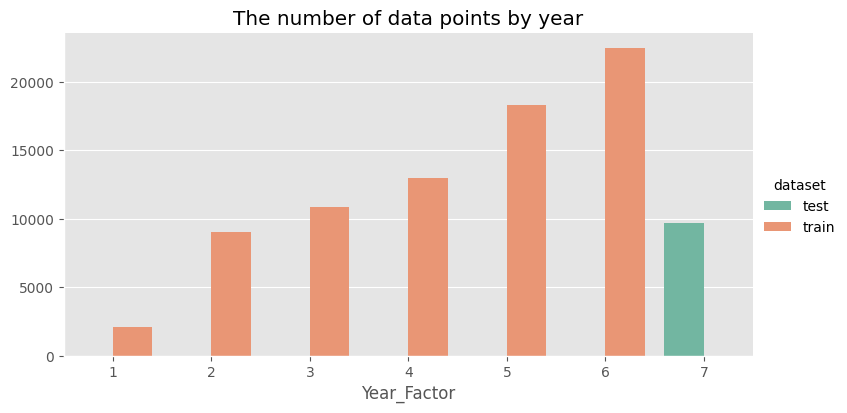

In [22]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

# encoded (morphed) value of original year

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6`.</div>

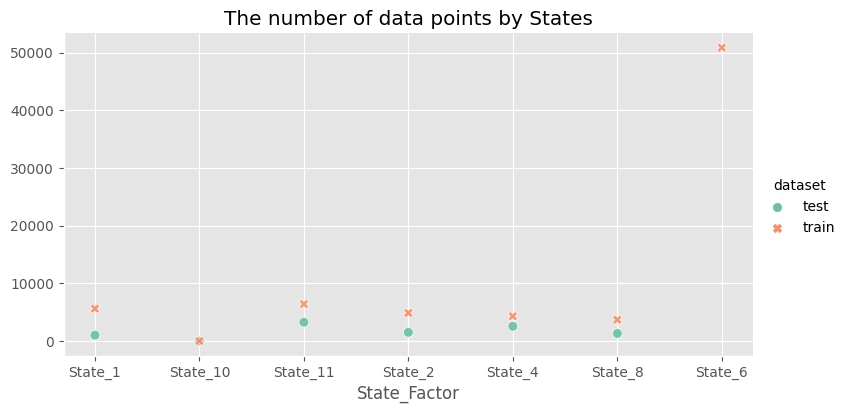

In [23]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

Text(0.5, 0, '')

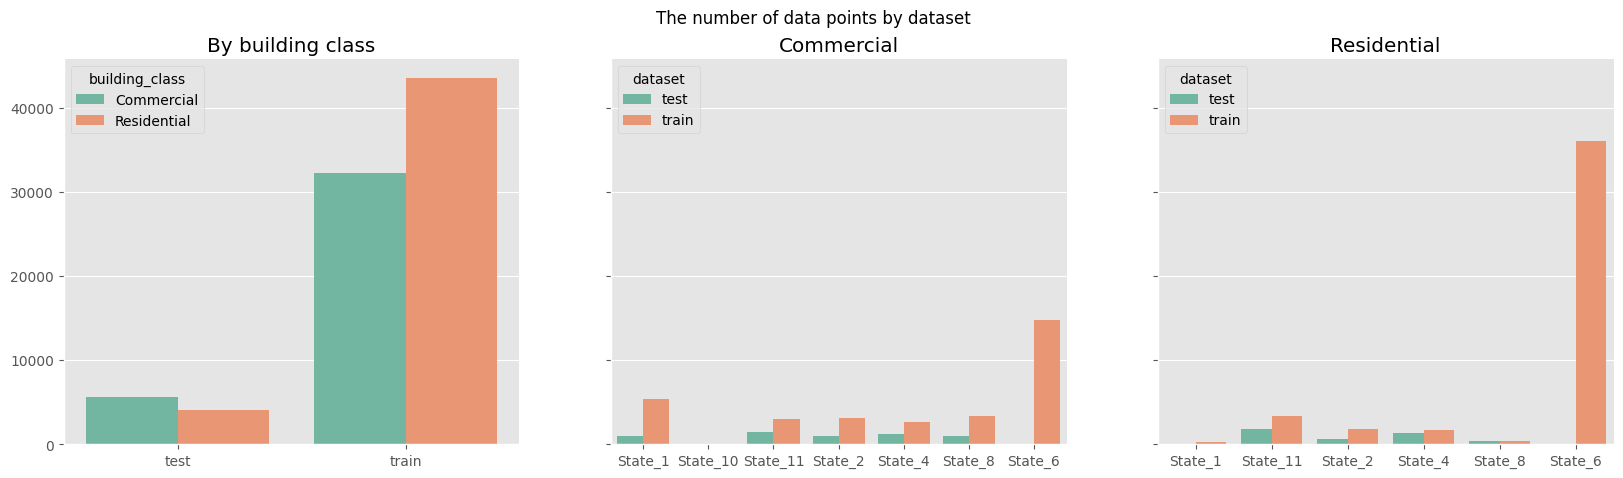

In [24]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.</div>

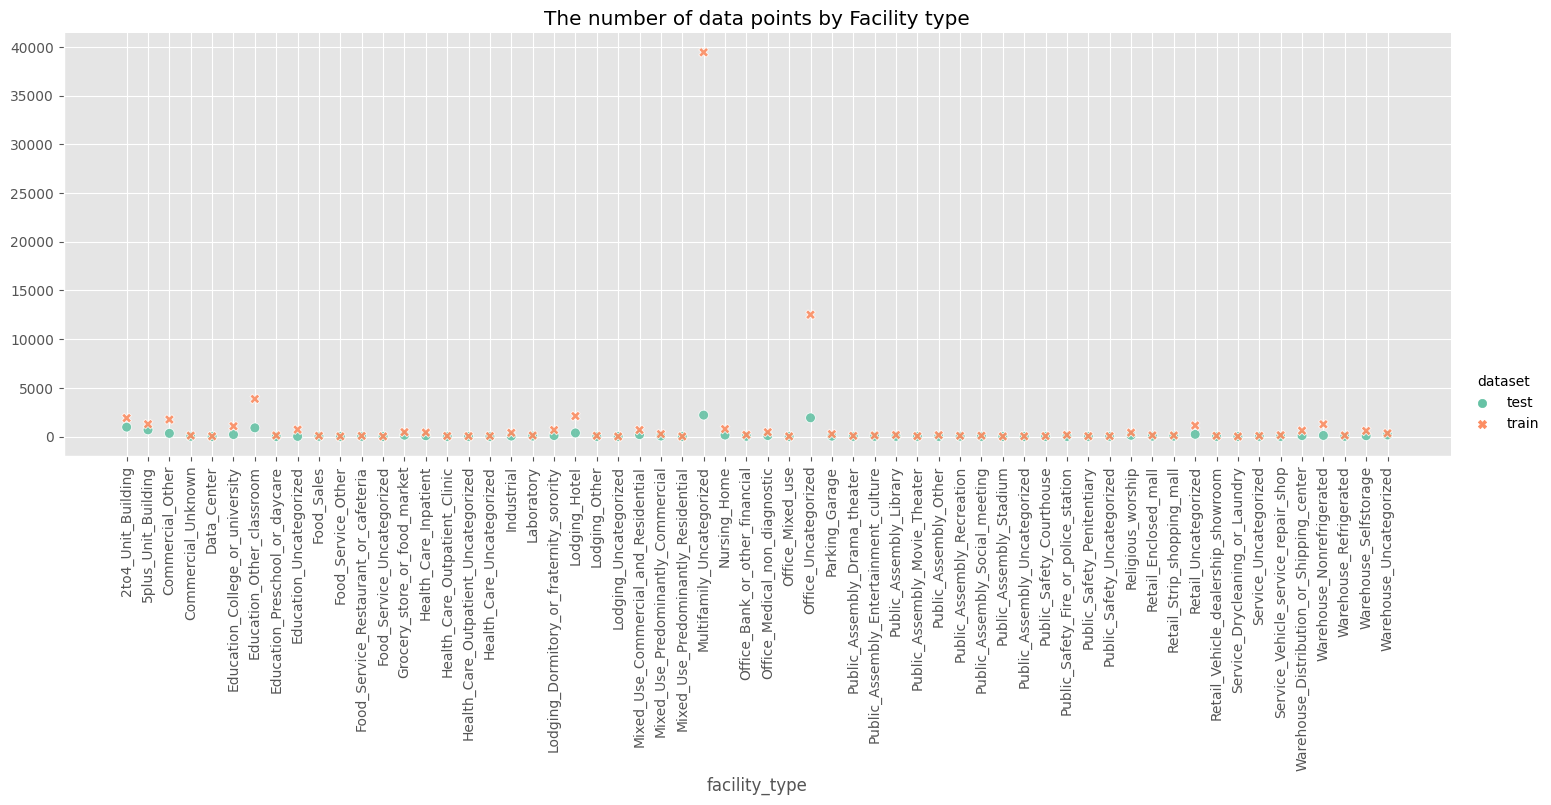

In [25]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values. Not quite sure what 0 signifies.</div>

In [26]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

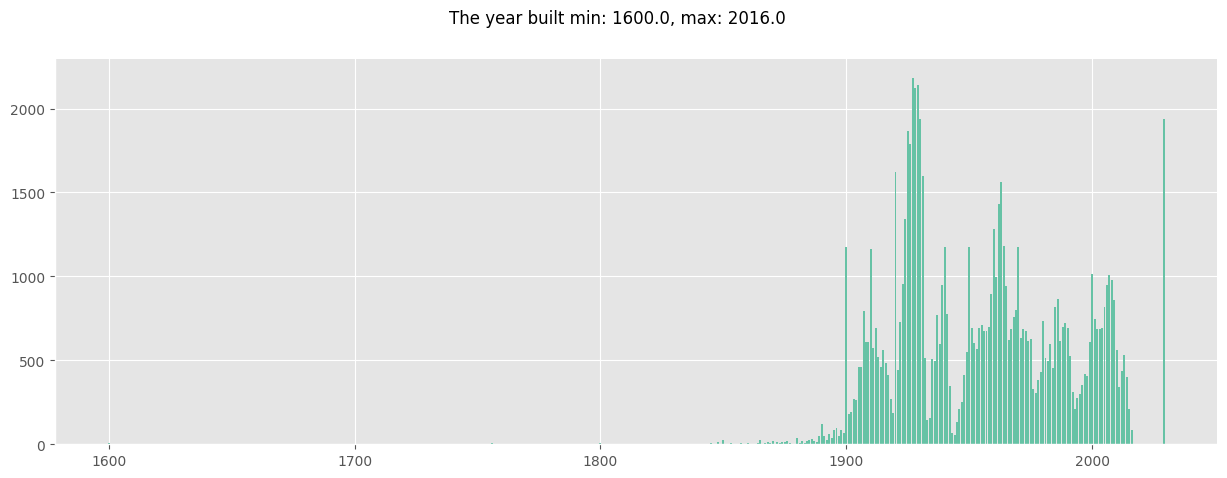

In [27]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. </div>

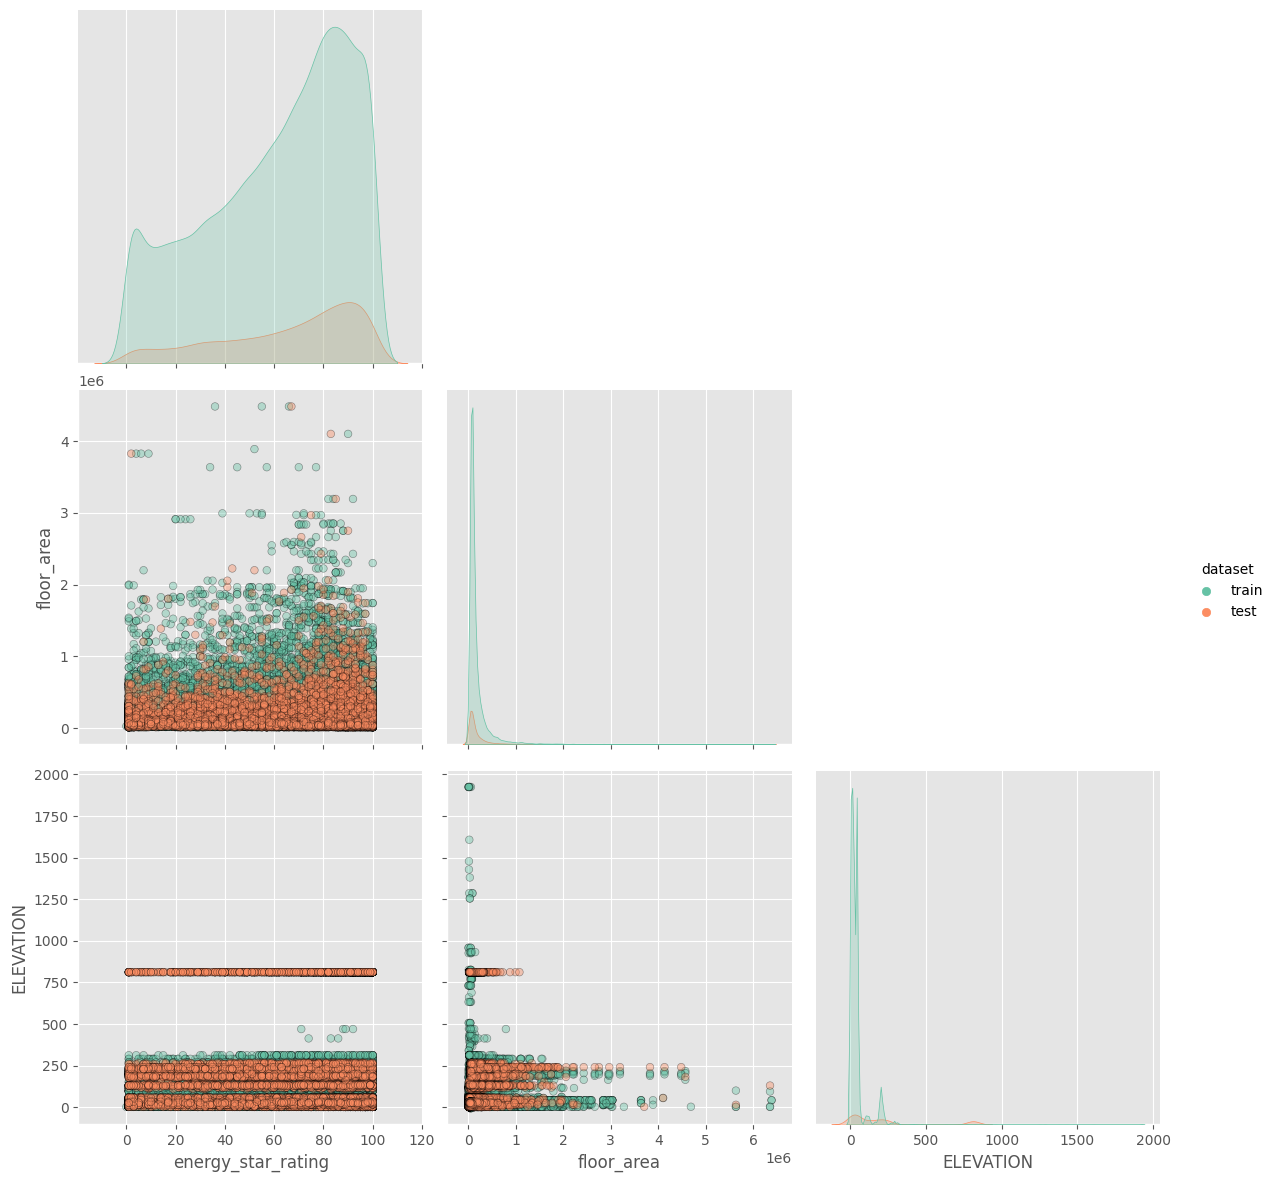

In [28]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. </div>

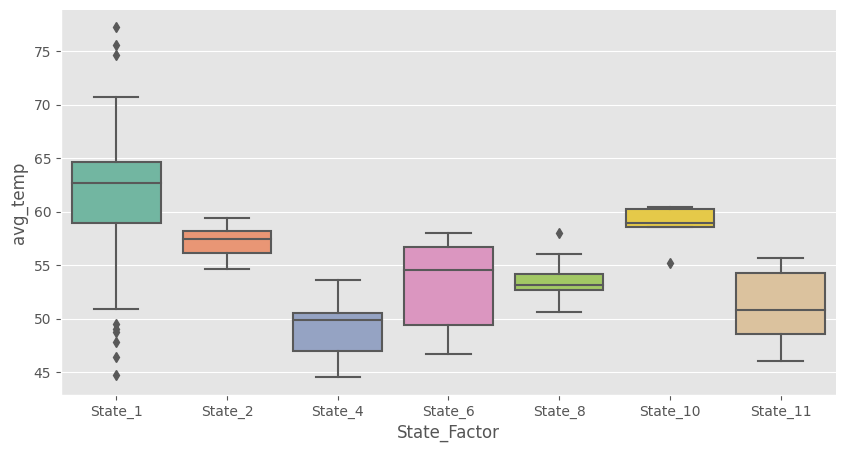

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');


# any one categorical col (with low unique vals)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.</div>

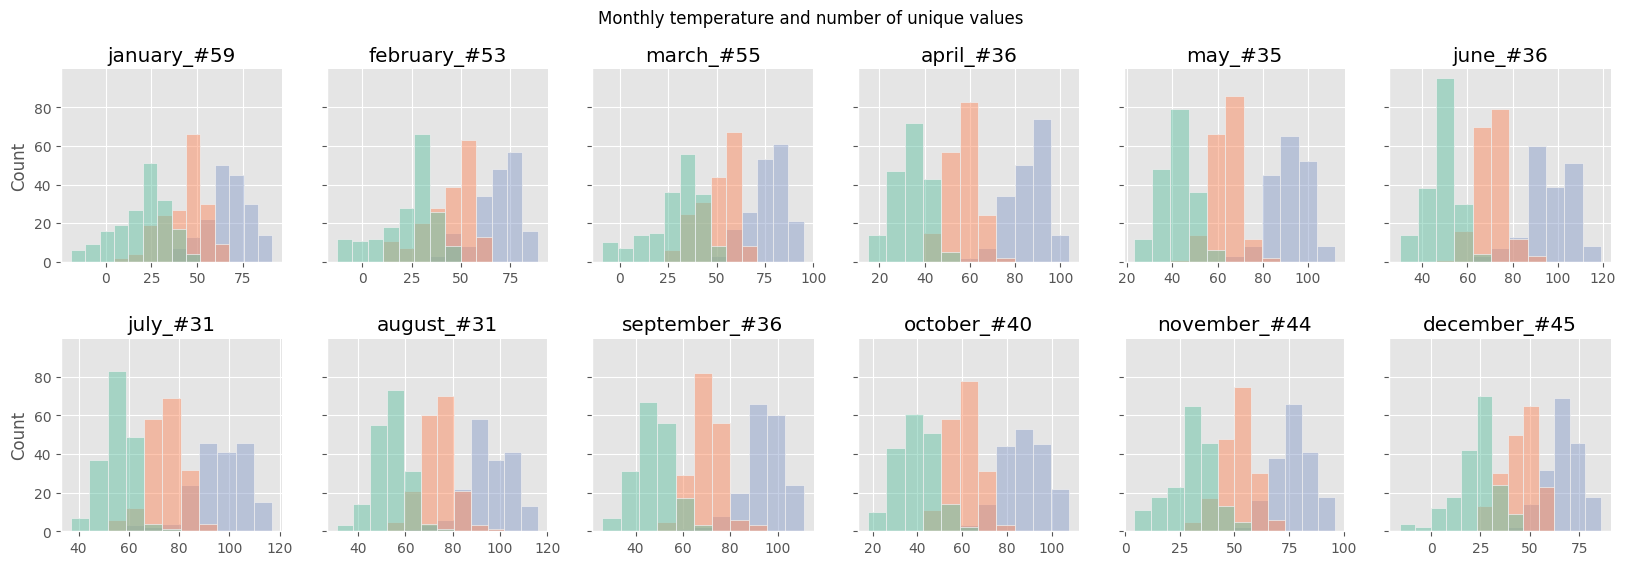

In [30]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Other weather related numerical columns also have few unique values.</div>

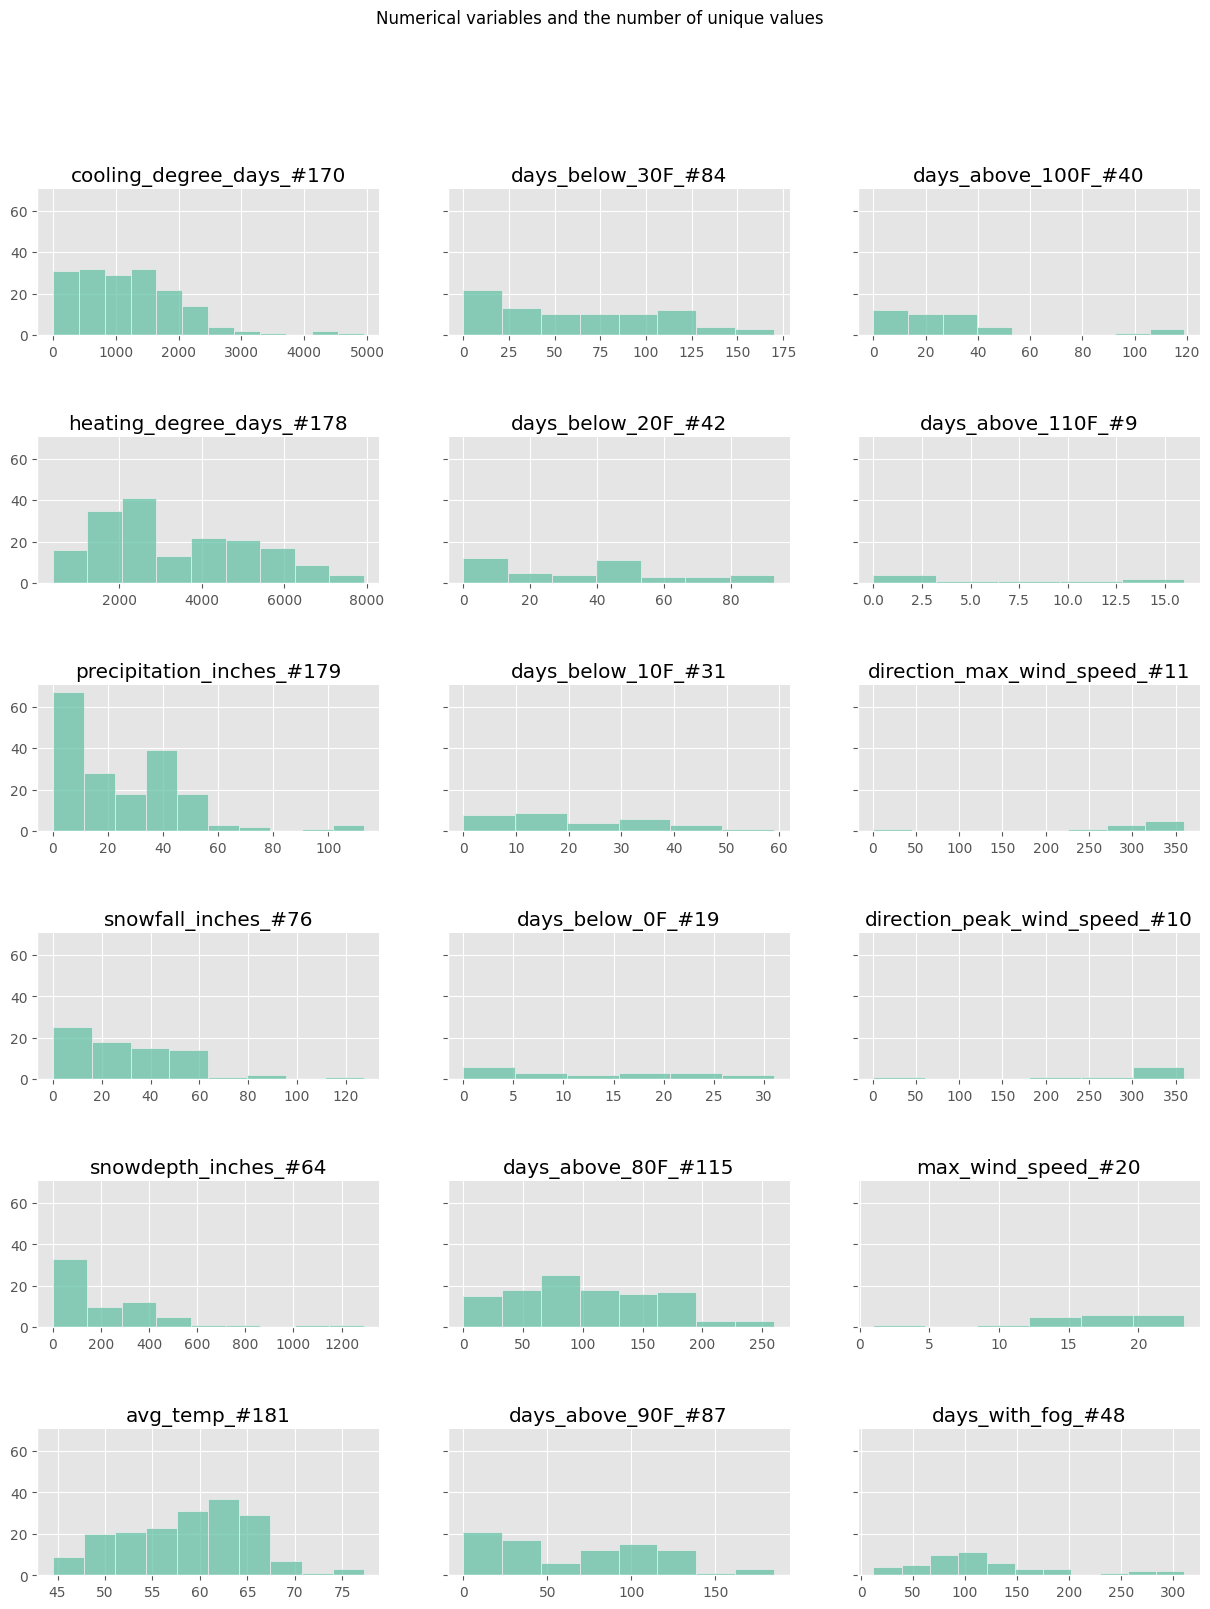

In [31]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

In [32]:

# # larger datasets
# find groups in the columns
# elevation, floor areas (dimentions)
# temperature
# wind




### <span style="font-family:cursive;text-align:center">📌Target Variable Exploration (EUI)</span>

In [33]:

# # larger datasets
# find groups in the columns
# elevation, floor areas (dimentions)
# temperature
# wind




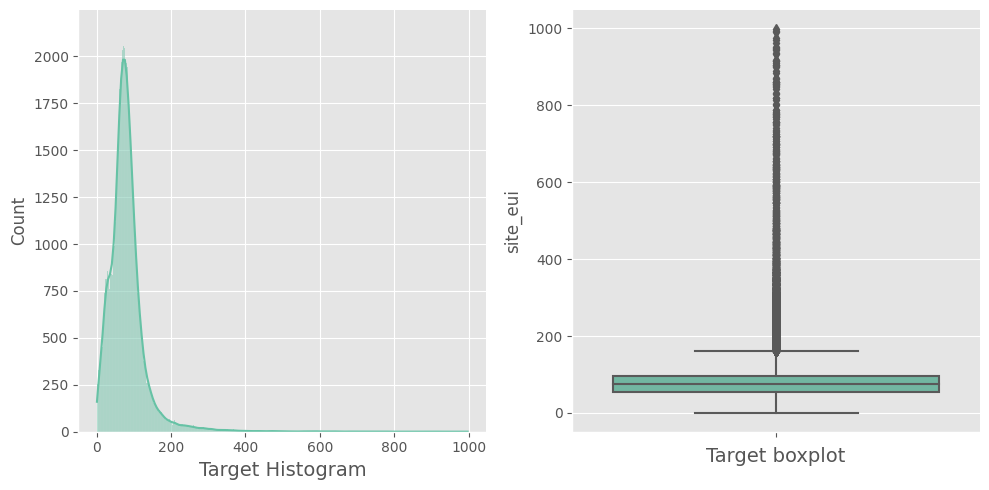

In [34]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">State 2 and 4 have slightly higher EUI and State 11 and 8 have lower EUI level.</div>

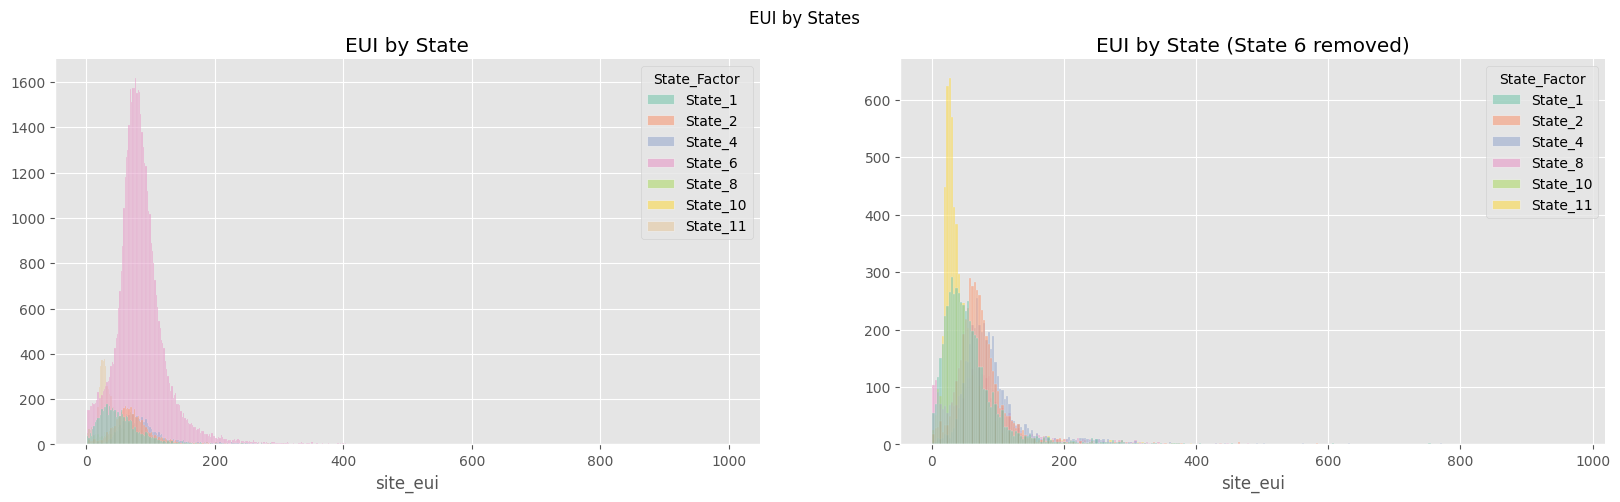

In [35]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

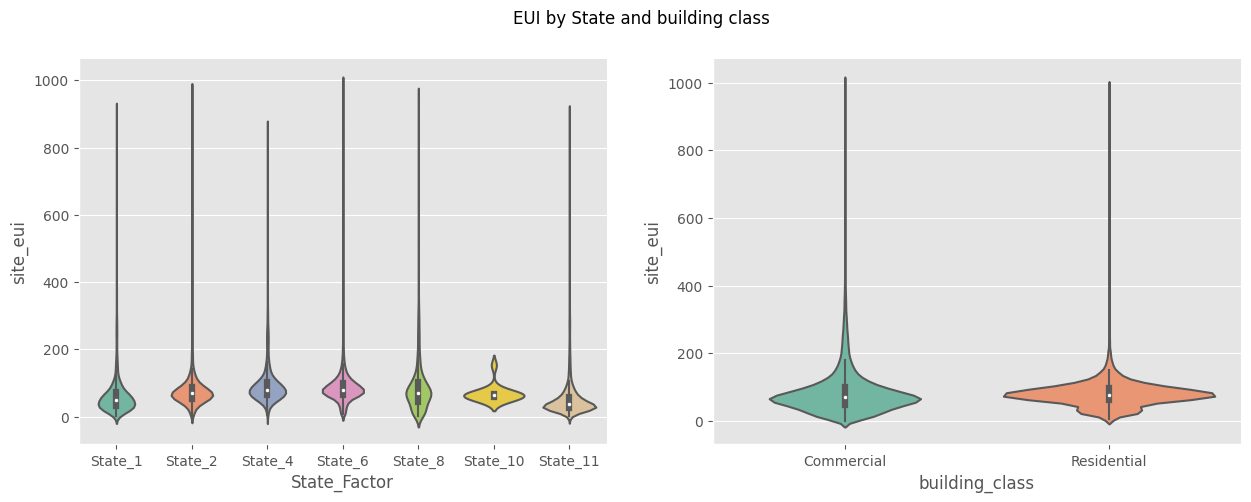

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.</div>

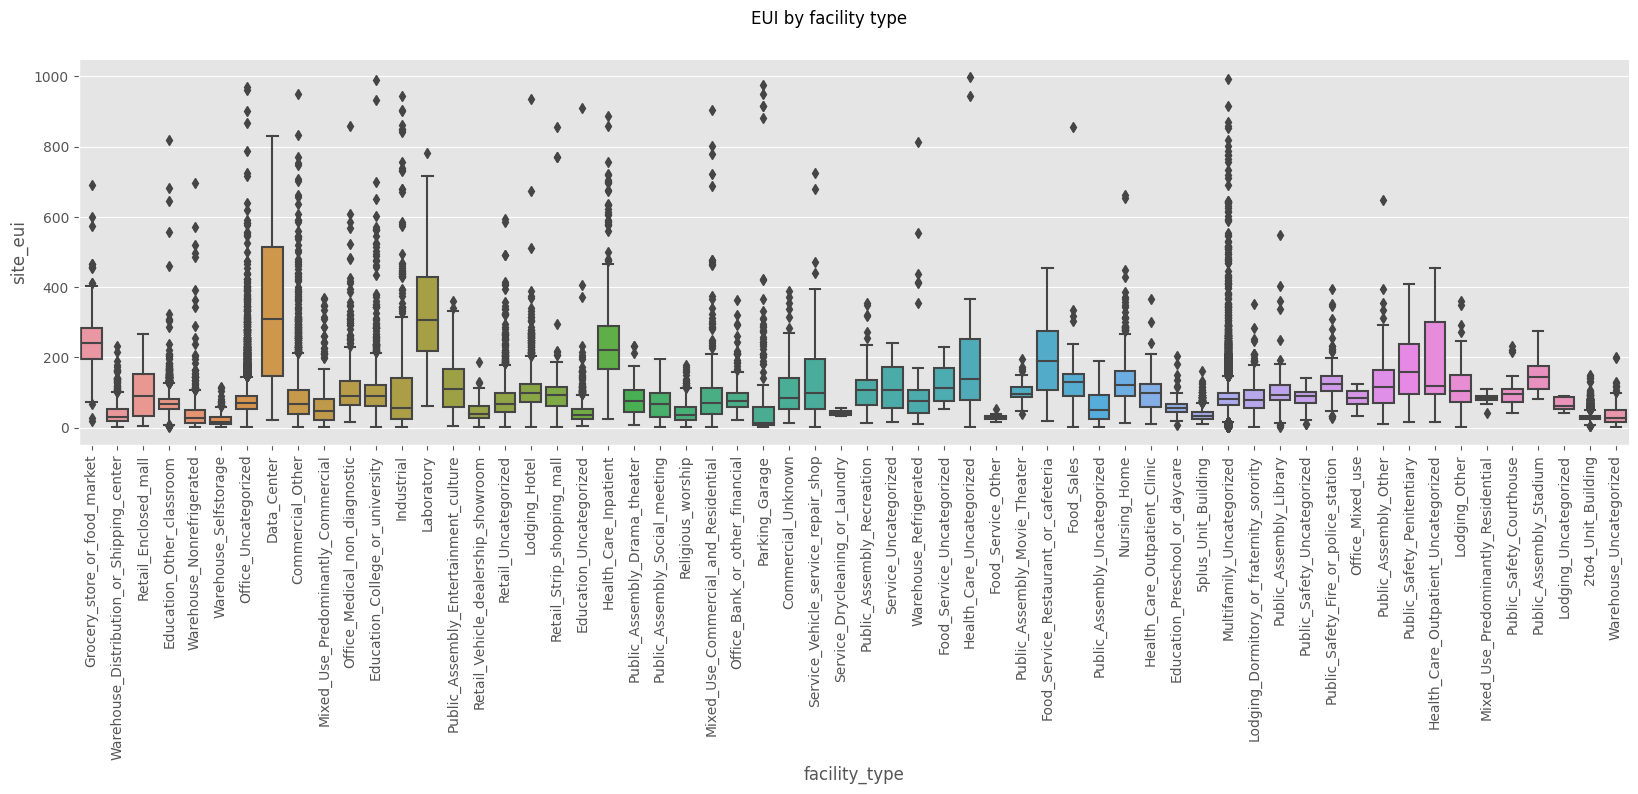

In [37]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.</div>

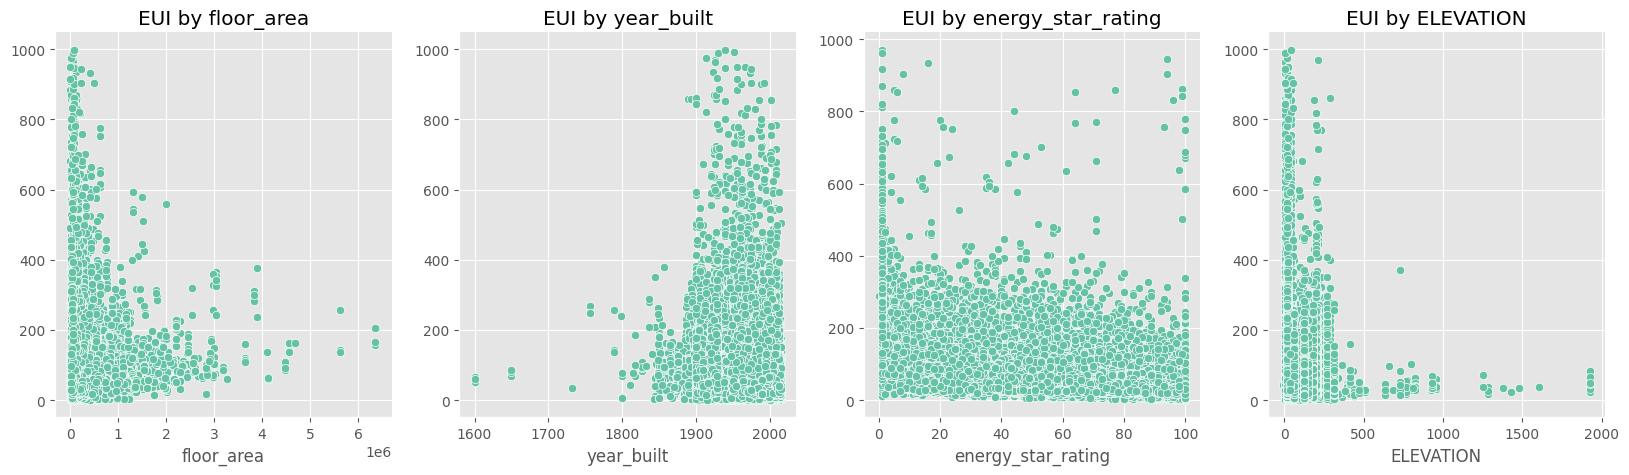

In [38]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.</div>

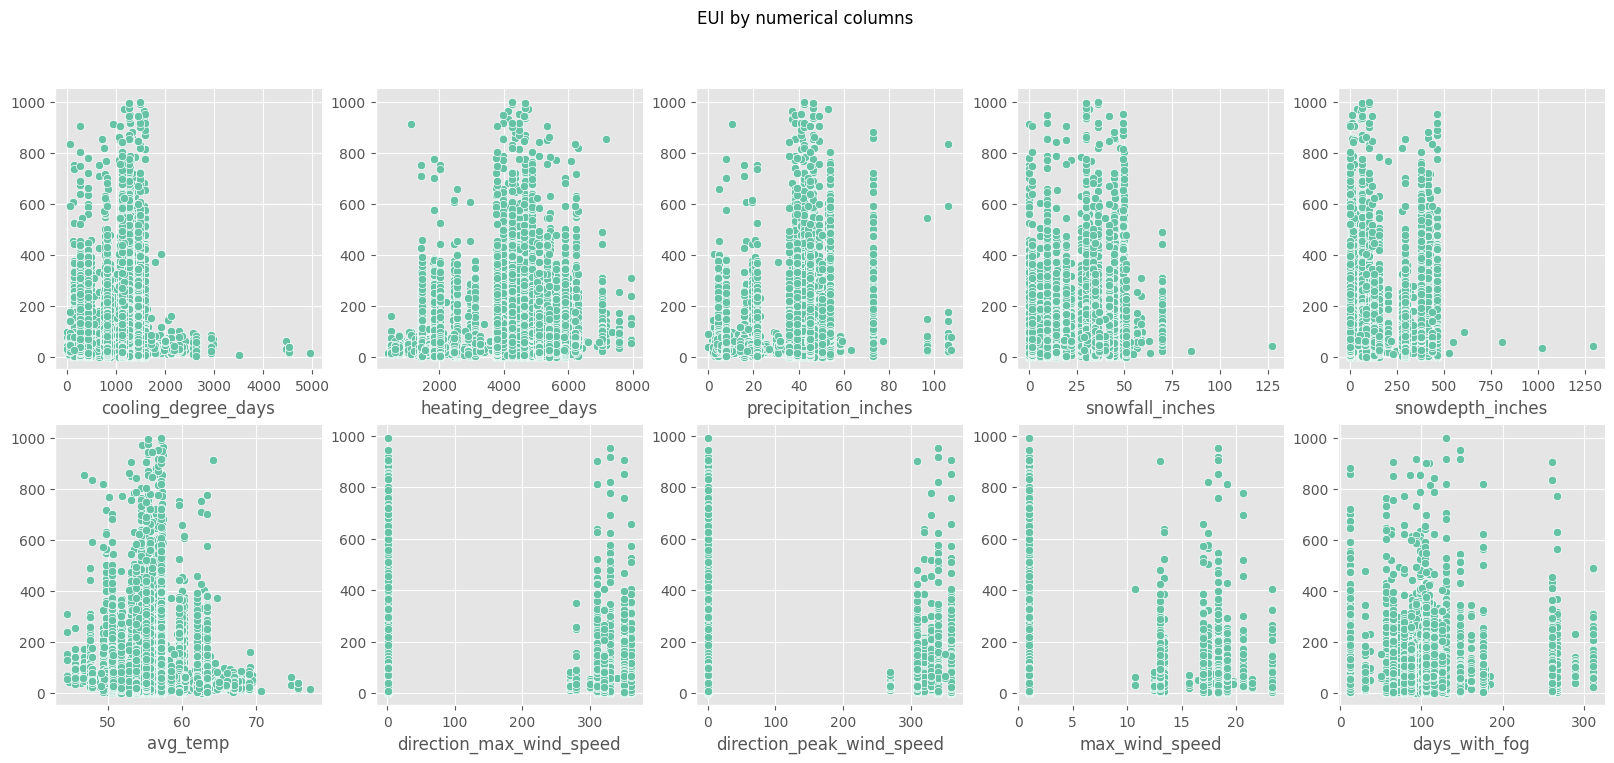

In [39]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>

- Categorical variables such as `State_Factor`, `building_class` and `facility_type` might have some correlation with `EUI`.
- `State_6` is not present in `test` set. State 6 removed training data should be tested.
- `floor_area`, `energe_star_rating` should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between `EUI` and weather related variables. However, this doesn't deny non-linear relationships among the variables.
- Variables with more than 50% `NA` values should not be imputed (in my opinion) and better to be not included in the training set.
- Weather variables have few unique values repeated throughout the datapoints. Not sure how this duplicated values might affect the modeling and prediction.

# <span style="font-family:cursive;text-align:center">⚙️ Preprocessing</span>



<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    we will suppose that two  if two buildings have the same values for these features;   
they are the same building, in other words groupby_cols = (building_id)


Removing duplicates by clubbing similar building data
</div>

In [40]:
# null values,
# weather data points have a lot of repetition
# categories encoded

In [41]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    Null imputation for categorical values: <b>KNN Imputing</b>
</div>

In [42]:
df_all_one_hot = df_all.copy()

cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all_one_hot[col], dummy_na=False)
    for ohe_col in dummies:
        df_all_one_hot[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [43]:
df_all_one_hot

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
85457            7     State_11    Residential   
85458            7     State_11    Residential   
85459            7     State_11    Residential   
85460            7     State_11    Residential   
85461            7     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
85457                        5plus_Unit_Building    305925.0      2013.0   
85458                        5plus_Unit_Building     34909.0      1910.0   
85459                        5plus_Unit_Building     42393.0      2014.0   
85460                        5plus_Unit_Building     25368.0      1992.0   
85461                        5plus_Unit_Building     45640.0      1994.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36          50.50000   
1                    45.0        1.8                36          50.50000   
2                    97.0        1.8                36          50.50000   
3                    46.0        1.8                36          50.50000   
4                   100.0        2.4                36          50.50000   
...                   ...        ...               ...               ...   
85457                99.0      812.0                21          38.66129   
85458                94.0       26.5                21          38.66129   
85459                94.0      812.0                21          38.66129   
85460                79.0      812.0                21          38.66129   
85461                87.0       26.5                21          38.66129   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
85457                54                 28          41.625000   
85458                54                 28          41.625000   
85459                54                 28          41.625000   
85460                54                 28          41.625000   
85461                54                 28          41.625000   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
85457                 59              33       46.500000              59   
85458                 59              33       46.500000              59   
85459                 59              33       46.500000              59   
85460                 59              3

In [44]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False

knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]


# df1: no null values
# tmp: seperated columns
#     df1 + tmp  => final df



# null points  => neighbours (most gets imputed)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <b>Target encoding</b> for categorical columns.  
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

Note: You can also use target encoding to convert categorical columns to numeric. 

> “features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

[Target Encoding Vs. One-hot Encoding with Simple Examples](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)
<div>

In [45]:
df_all_te = df_all.copy()

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all_te[f'te_{col}'] = encoder.fit_transform(df_all_te[col], df_all_te[target])

In [46]:
df_all_te

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0              1.0     61242.0      1942.0                11.0        2.4   
1              1.0    274000.0      1955.0                45.0        1.8   
2              1.0    280025.0      1951.0                97.0        1.8   
3              1.0     55325.0      1980.0                46.0        1.8   
4              1.0     66000.0      1985.0               100.0        2.4   
...            ...         ...         ...                 ...        ...   
85457          7.0    305925.0      2013.0                99.0      812.0   
85458          7.0     34909.0      1910.0                94.0       26.5   
85459          7.0     42393.0      2014.0                94.0      812.0   
85460          7.0     25368.0      1992.0                79.0      812.0   
85461          7.0     45640.0      1994.0                87.0       26.5   

       january_min_temp  january_avg_temp  january_max_temp  \
0                  36.0          50.50000              68.0   
1                  36.0          50.50000              68.0   
2                  36.0          50.50000              68.0   
3                  36.0          50.50000              68.0   
4                  36.0          50.50000              68.0   
...                 ...               ...               ...   
85457              21.0          38.66129              54.0   
85458              21.0          38.66129              54.0   
85459              21.0          38.66129              54.0   
85460              21.0          38.66129              54.0   
85461              21.0          38.66129              54.0   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   35.0          50.589286               73.0   
1                   35.0          50.589286               73.0   
2                   35.0          50.589286               73.0   
3                   35.0          50.589286               73.0   
4                   35.0          50.589286               73.0   
...                  ...                ...                ...   
85457               28.0          41.625000               59.0   
85458               28.0          41.625000               59.0   
85459               28.0          41.625000               59.0   
85460               28.0          41.625000               59.0   
85461               28.0          41.625000               59.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                40.0       53.693548            80.0            41.0   
1                40.0       53.693548            80.0            41.0   
2                40.0       53.693548            80.0            41.0   
3                40.0       53.693548            80.0            41.0   
4                40.0       53.693548            80.0            41.0   
...               ...             ...             ...             ...   
85457            33.0       46.500000            59.0            37.0   
85458            33.0       46.500000            59.0            37.0   
85459            33.0       46.500000            59.0            37.0   
85460            33.0       46.500000            59.0            37.0   
85461            33.0       46.500000            59.0            37.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0           55.500000            78.0          46.0     56.854839   
1           55.500000            78.0          46.0     56.854839   
2           55.500000            78.0          46.0     56.854839   
3           55.500000            78.0          46.0     56.854839   
4           55.500000            78.0          46.0     56.854839   
...               ...             ...           ...           ...   
85457       50.833333            67.0          42.0     58.112903   
85458       50.833333            67.0          42.0     58.112903   
85459       50.833333            6

# <span style="font-family:cursive;text-align:center">Feature Engineering</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    <font size='3.5pt'><b>Weather based features</b></font>

we will extract new weather statistics from the building location weather features

In [47]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all_te.columns if 'temp' in col]

df_all_te['min_temp'] = df_all_te[temp].min(axis=1)
df_all_te['max_temp'] = df_all_te[temp].max(axis=1)
df_all_te['avg_temp'] = df_all_te[temp].mean(axis=1)
df_all_te['std_temp'] = df_all_te[temp].std(axis=1)
df_all_te['skew_temp'] = df_all_te[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all_te.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all_te['min_winter_temp'] = df_all_te[winter_temp].min(axis=1)
df_all_te['max_winter_temp'] = df_all_te[winter_temp].max(axis=1)
df_all_te['avg_winter_temp'] = df_all_te[winter_temp].mean(axis=1)
df_all_te['std_winter_temp'] = df_all_te[winter_temp].std(axis=1)
df_all_te['skew_winter_temp'] = df_all_te[winter_temp].skew(axis=1)
### spring
df_all_te['min_spring_temp'] = df_all_te[spring_temp].min(axis=1)
df_all_te['max_spring_temp'] = df_all_te[spring_temp].max(axis=1)
df_all_te['avg_spring_temp'] = df_all_te[spring_temp].mean(axis=1)
df_all_te['std_spring_temp'] = df_all_te[spring_temp].std(axis=1)
df_all_te['skew_spring_temp'] = df_all_te[spring_temp].skew(axis=1)
### summer
df_all_te['min_summer_temp'] = df_all_te[summer_temp].min(axis=1)
df_all_te['max_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['avg_summer_temp'] = df_all_te[summer_temp].mean(axis=1)
df_all_te['std_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['skew_summer_temp'] = df_all_te[summer_temp].max(axis=1)
## autumn
df_all_te['min_autumn_temp'] = df_all_te[autumn_temp].min(axis=1)
df_all_te['max_autumn_temp'] = df_all_te[autumn_temp].max(axis=1)
df_all_te['avg_autumn_temp'] = df_all_te[autumn_temp].mean(axis=1)
df_all_te['std_autumn_temp'] = df_all_te[autumn_temp].std(axis=1)
df_all_te['skew_autumn_temp'] = df_all_te[autumn_temp].skew(axis=1)

In [48]:
df_all_te['month_cooling_degree_days'] = df_all_te['cooling_degree_days']/12
df_all_te['month_heating_degree_days'] = df_all_te['heating_degree_days']/12

In [49]:
df_all_te[temp]

january_min_temp  january_avg_temp  january_max_temp  \
0                  36.0          50.50000              68.0   
1                  36.0          50.50000              68.0   
2                  36.0          50.50000              68.0   
3                  36.0          50.50000              68.0   
4                  36.0          50.50000              68.0   
...                 ...               ...               ...   
85457              21.0          38.66129              54.0   
85458              21.0          38.66129              54.0   
85459              21.0          38.66129              54.0   
85460              21.0          38.66129              54.0   
85461              21.0          38.66129              54.0   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   35.0          50.589286               73.0   
1                   35.0          50.589286               73.0   
2                   35.0          50.589286               73.0   
3                   35.0          50.589286               73.0   
4                   35.0          50.589286               73.0   
...                  ...                ...                ...   
85457               28.0          41.625000               59.0   
85458               28.0          41.625000               59.0   
85459               28.0          41.625000               59.0   
85460               28.0          41.625000               59.0   
85461               28.0          41.625000               59.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                40.0       53.693548            80.0            41.0   
1                40.0       53.693548            80.0            41.0   
2                40.0       53.693548            80.0            41.0   
3                40.0       53.693548            80.0            41.0   
4                40.0       53.693548            80.0            41.0   
...               ...             ...             ...             ...   
85457            33.0       46.500000            59.0            37.0   
85458            33.0       46.500000            59.0            37.0   
85459            33.0       46.500000            59.0            37.0   
85460            33.0       46.500000            59.0            37.0   
85461            33.0       46.500000            59.0            37.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0           55.500000            78.0          46.0     56.854839   
1           55.500000            78.0          46.0     56.854839   
2           55.500000            78.0          46.0     56.854839   
3           55.500000            78.0          46.0     56.854839   
4           55.500000            78.0          46.0     56.854839   
...               ...             ...           ...           ...   
85457       50.833333            67.0          42.0     58.112903   
85458       50.833333            67.0          42.0     58.112903   
85459       50.833333            67.0          42.0     58.112903   
85460       50.833333            67.0          42.0     58.112903   
85461       50.833333            67.0          42.0     58.112903   

       may_max_temp  june_min_temp  june_avg_temp  june_max_temp  \
0              84.0           50.0      60.500000           90.0   
1              84.0           50.0      60.500000           90.0   
2              84.0           50.0      60.500000           90.0   
3              84.0           50.0      60.500000           90.0   
4              84.0           50.0      60.500000           90.0   
...             ...            ...            ...            ...   
85457          82.0           45.0      62.583333           93.0   
85458          82.0           45.0      62.583333           93.0   
85459          82.0           45.0      62.583333           93.0   
85460          82.0           45.0      62.583333           93.0   
854

In [50]:
df_all_te['cooling_degree_days']

0        115.0
1        115.0
2        115.0
3        115.0
4        115.0
         ...  
85457    345.0
85458    345.0
85459    345.0
85460    345.0
85461    345.0
Name: cooling_degree_days, Length: 85462, dtype: float64

In [51]:
df_all_te[['min_winter_temp', 'max_winter_temp', 'avg_winter_temp', 'std_winter_temp', 'skew_winter_temp',
           'min_spring_temp', 'max_spring_temp', 'avg_spring_temp', 'std_spring_temp', 'skew_spring_temp',
           'min_summer_temp', 'max_summer_temp', 'avg_summer_temp', 'std_summer_temp', 'skew_summer_temp',
           'min_autumn_temp', 'max_autumn_temp', 'avg_autumn_temp', 'std_autumn_temp', 'skew_autumn_temp']]

min_winter_temp  max_winter_temp  avg_winter_temp  std_winter_temp  \
0                 35.0             73.0        52.151498        15.290780   
1                 35.0             73.0        52.151498        15.290780   
2                 35.0             73.0        52.151498        15.290780   
3                 35.0             73.0        52.151498        15.290780   
4                 35.0             73.0        52.151498        15.290780   
...                ...              ...              ...              ...   
85457             21.0             59.0        40.646505        13.378875   
85458             21.0             59.0        40.646505        13.378875   
85459             21.0             59.0        40.646505        13.378875   
85460             21.0             59.0        40.646505        13.378875   
85461             21.0             59.0        40.646505        13.378875   

       skew_winter_temp  min_spring_temp  max_spring_temp  avg_spring_temp  \
0              0.280260             40.0             84.0        59.449821   
1              0.280260             40.0             84.0        59.449821   
2              0.280260             40.0             84.0        59.449821   
3              0.280260             40.0             84.0        59.449821   
4              0.280260             40.0             84.0        59.449821   
...                 ...              ...              ...              ...   
85457         -0.007697             33.0             82.0        52.827360   
85458         -0.007697             33.0             82.0        52.827360   
85459         -0.007697             33.0             82.0        52.827360   
85460         -0.007697             33.0             82.0        52.827360   
85461         -0.007697             33.0             82.0        52.827360   

       std_spring_temp  skew_spring_temp  min_summer_temp  max_summer_temp  \
0            17.044754          0.438715             50.0             90.0   
1            17.044754          0.438715             50.0             90.0   
2            17.044754          0.438715             50.0             90.0   
3            17.044754          0.438715             50.0             90.0   
4            17.044754          0.438715             50.0             90.0   
...                ...               ...              ...              ...   
85457        15.503298          0.636895             45.0             93.0   
85458        15.503298          0.636895             45.0             93.0   
85459        15.503298          0.636895             45.0             93.0   
85460        15.503298          0.636895             45.0             93.0   
85461        15.503298          0.636895             45.0             93.0   

       avg_summer_temp  std_summer_temp  skew_summer_temp  min_autumn_temp  \
0            66.487455             90.0              90.0             43.0   
1            66.487455             90.0              90.0             43.0   
2            66.487455             90.0              90.0             43.0   
3            66.487455             90.0              90.0             43.0   
4            66.487455             90.0              90.0             43.0   
...                ...              ...               ...              ...   
85457        68.593489             93.0              93.0             30.0   
85458        68.593489             93.0              93.0             30.0   
85459        68.593489             93.0              93.0             30.0   
85460        68.593489             93.0              93.0             30.0   
85461        68.593489             93.0              93.0             30.0   

       max_autumn_temp  avg_autumn_temp  std_autumn_temp  skew_autumn_temp  
0                 90.0        63.162903        16.101723          0.508062  
1                 90.0        63.162903        16.101723          0.508062  
2                 90.0        63.162903 

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    <font size='3.5pt'><b>Buildig based feature:</b></font>

we will extract building statistics

In [52]:
# total area
df_all_te['building_area'] = df_all_te['floor_area'] * df_all_te['ELEVATION']
# rating energy by floor
df_all_te['floor_energy_star_rating'] = df_all_te['energy_star_rating']/df_all_te['ELEVATION']


In [53]:
df_all_te[["floor_area", "ELEVATION", "energy_star_rating", "floor_energy_star_rating", "building_area"]]

floor_area  ELEVATION  energy_star_rating  floor_energy_star_rating  \
0         61242.0        2.4                11.0                  4.583333   
1        274000.0        1.8                45.0                 25.000000   
2        280025.0        1.8                97.0                 53.888889   
3         55325.0        1.8                46.0                 25.555556   
4         66000.0        2.4               100.0                 41.666667   
...           ...        ...                 ...                       ...   
85457    305925.0      812.0                99.0                  0.121921   
85458     34909.0       26.5                94.0                  3.547170   
85459     42393.0      812.0                94.0                  0.115764   
85460     25368.0      812.0                79.0                  0.097291   
85461     45640.0       26.5                87.0                  3.283019   

       building_area  
0           146980.8  
1           493200.0  
2           504045.0  
3            99585.0  
4           158400.0  
...              ...  
85457    248411100.0  
85458       925088.5  
85459     34423116.0  
85460     20598816.0  
85461      1209460.0  

[85462 rows x 5 columns]

### <span style="font-family:cursive;text-align:center">Checking target variable transformation</span>

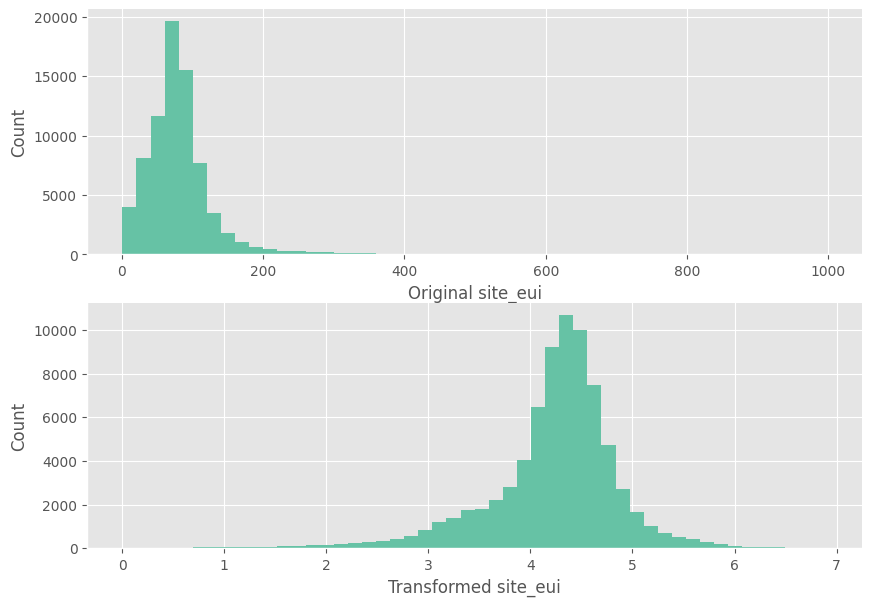

In [54]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

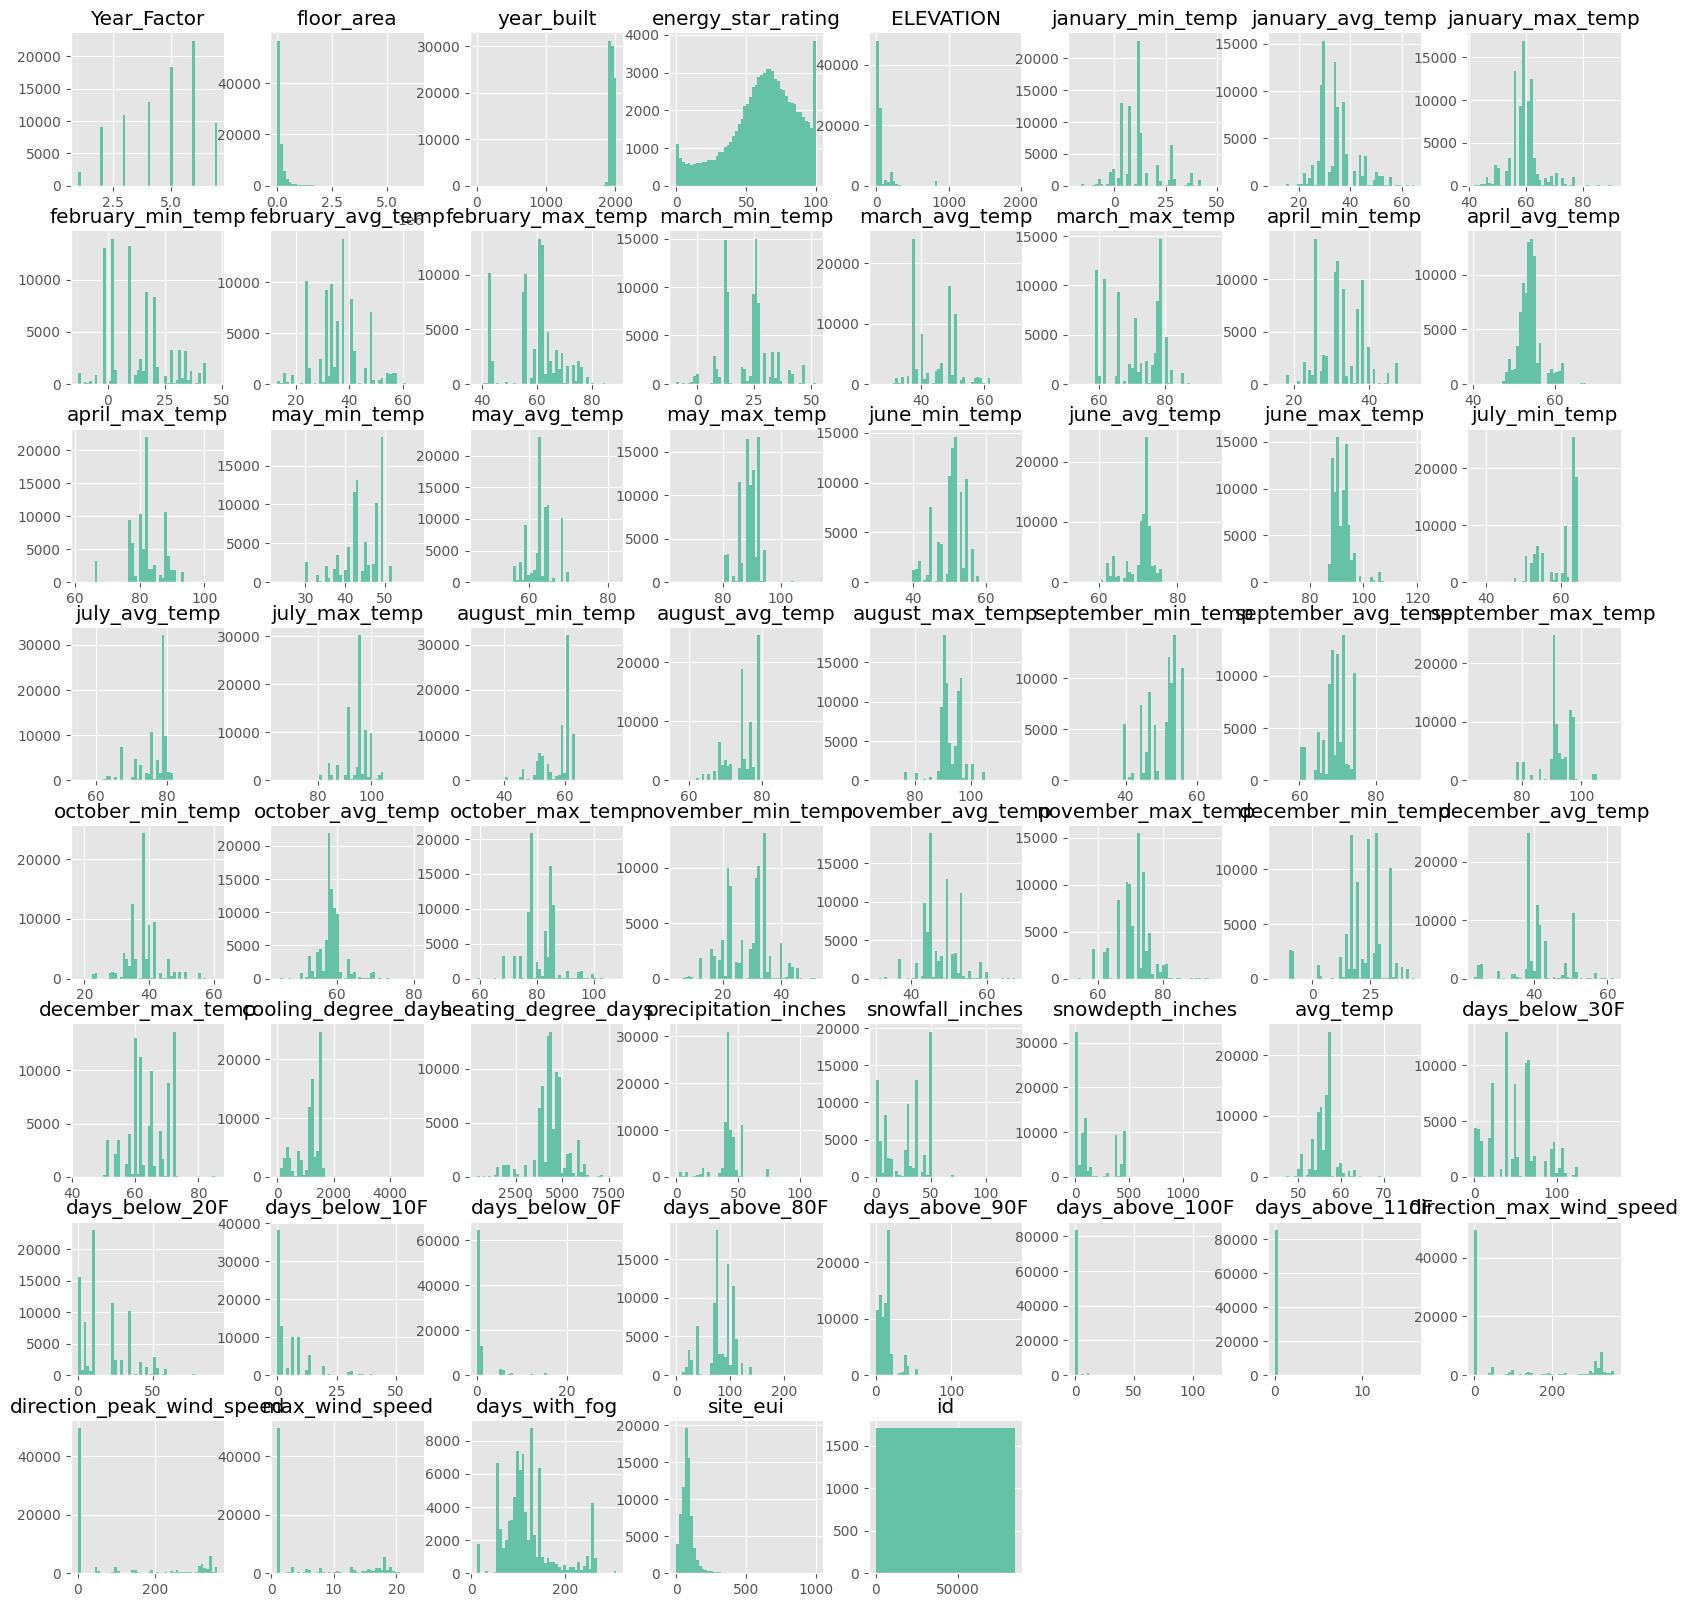

In [55]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [56]:
df_all_te[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.716647
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    Binarize very skewed variables

In [57]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all_te[var] = np.where(df_all_te[var]==0, 0, 1)

### <span style="font-family:cursive;text-align:center">Saving feature dataset</span>

In [58]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set_TEonly.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('feature_transformed_set_TEonly.pkl')

In [59]:
df_all_te.shape

(85462, 96)

In [60]:
df_all_te.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0          1.0     61242.0      1942.0                11.0        2.4   
1          1.0    274000.0      1955.0                45.0        1.8   
2          1.0    280025.0      1951.0                97.0        1.8   
3          1.0     55325.0      1980.0                46.0        1.8   
4          1.0     66000.0      1985.0               100.0        2.4   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              36.0              50.5              68.0               35.0   
1              36.0              50.5              68.0               35.0   
2              36.0              50.5              68.0               35.0   
3              36.0              50.5              68.0               35.0   
4              36.0              50.5              68.0               35.0   

   february_avg_temp  february_max_temp  march_min_temp  march_avg_temp  \
0          50.589286               73.0            40.0       53.693548   
1          50.589286               73.0            40.0       53.693548   
2          50.589286               73.0            40.0       53.693548   
3          50.589286               73.0            40.0       53.693548   
4          50.589286               73.0            40.0       53.693548   

   march_max_temp  april_min_temp  april_avg_temp  april_max_temp  \
0            80.0            41.0            55.5            78.0   
1            80.0            41.0            55.5            78.0   
2            80.0            41.0            55.5            78.0   
3            80.0            41.0            55.5            78.0   
4            80.0            41.0            55.5            78.0   

   may_min_temp  may_avg_temp  may_max_temp  june_min_temp  june_avg_temp  \
0          46.0     56.854839          84.0           50.0           60.5   
1          46.0     56.854839          84.0           50.0           60.5   
2          46.0     56.854839          84.0           50.0           60.5   
3          46.0     56.854839          84.0           50.0           60.5   
4          46.0     56.854839          84.0           50.0           60.5   

   june_max_temp  july_min_temp  july_avg_temp  july_max_temp  \
0           90.0           52.0      62.725806           84.0   
1           90.0           52.0      62.725806           84.0   
2           90.0           52.0      62.725806           84.0   
3           90.0           52.0      62.725806           84.0   
4           90.0           52.0      62.725806           84.0   

   august_min_temp  august_avg_temp  august_max_temp  september_min_temp  \
0             52.0         62.16129             85.0                52.0   
1             52.0         62.16129             85.0                52.0   
2             52.0         62.16129             85.0                52.0   
3             52.0         62.16129             85.0                52.0   
4             52.0         62.16129             85.0                52.0   

   september_avg_temp  september_max_temp  october_min_temp  october_avg_temp  \
0               64.65                90.0              47.0         63.016129   
1               64.65                90.0              47.0         63.016129   
2               64.65                90.0              47.0         63.016129   
3               64.65                90.0              47.0         63.016129   
4               64.65                90.0              47.0         63.016129   

   october_max_temp  ...  building_class  \
0              83.0  ...      Commercial   
1              83.0  ...      Commercial   
2              83.0  ...      Commercial   
3              83.0  ...      Commercial   
4              83.0  ...      Commercial   

                               facility_type  dataset    site_eui  \
0               Grocery_store_or_food_market    train  248.682615   
1  Warehouse_Distribution_or

# <span style="font-family:cursive;text-align:center">🧰 Baseline Modelling</span>

In [61]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']
# typecasting numerical features
for col in df_all_te.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all_te[col] = df_all_te[col].astype('float64')

In [62]:
df_all_te.drop(columns=['State_Factor', 'facility_type', 'building_class'],inplace=True)

In [63]:
df_all_te

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0              1.0     61242.0      1942.0                11.0        2.4   
1              1.0    274000.0      1955.0                45.0        1.8   
2              1.0    280025.0      1951.0                97.0        1.8   
3              1.0     55325.0      1980.0                46.0        1.8   
4              1.0     66000.0      1985.0               100.0        2.4   
...            ...         ...         ...                 ...        ...   
85457          7.0    305925.0      2013.0                99.0      812.0   
85458          7.0     34909.0      1910.0                94.0       26.5   
85459          7.0     42393.0      2014.0                94.0      812.0   
85460          7.0     25368.0      1992.0                79.0      812.0   
85461          7.0     45640.0      1994.0                87.0       26.5   

       january_min_temp  january_avg_temp  january_max_temp  \
0                  36.0          50.50000              68.0   
1                  36.0          50.50000              68.0   
2                  36.0          50.50000              68.0   
3                  36.0          50.50000              68.0   
4                  36.0          50.50000              68.0   
...                 ...               ...               ...   
85457              21.0          38.66129              54.0   
85458              21.0          38.66129              54.0   
85459              21.0          38.66129              54.0   
85460              21.0          38.66129              54.0   
85461              21.0          38.66129              54.0   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   35.0          50.589286               73.0   
1                   35.0          50.589286               73.0   
2                   35.0          50.589286               73.0   
3                   35.0          50.589286               73.0   
4                   35.0          50.589286               73.0   
...                  ...                ...                ...   
85457               28.0          41.625000               59.0   
85458               28.0          41.625000               59.0   
85459               28.0          41.625000               59.0   
85460               28.0          41.625000               59.0   
85461               28.0          41.625000               59.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                40.0       53.693548            80.0            41.0   
1                40.0       53.693548            80.0            41.0   
2                40.0       53.693548            80.0            41.0   
3                40.0       53.693548            80.0            41.0   
4                40.0       53.693548            80.0            41.0   
...               ...             ...             ...             ...   
85457            33.0       46.500000            59.0            37.0   
85458            33.0       46.500000            59.0            37.0   
85459            33.0       46.500000            59.0            37.0   
85460            33.0       46.500000            59.0            37.0   
85461            33.0       46.500000            59.0            37.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0           55.500000            78.0          46.0     56.854839   
1           55.500000            78.0          46.0     56.854839   
2           55.500000            78.0          46.0     56.854839   
3           55.500000            78.0          46.0     56.854839   
4           55.500000            78.0          46.0     56.854839   
...               ...             ...           ...           ...   
85457       50.833333            67.0          42.0     58.112903   
85458       50.833333            67.0          42.0     58.112903   
85459       50.833333            6

In [64]:
train = df_all_te[df_all_te['dataset']=='train']
test = df_all_te[df_all_te['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

In [65]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 90)
Test: (9705, 90)
Samples:  (75757,)
Targets:  (9705,)


### <span style="font-family:cursive;text-align:center">Catboost</span>

In [66]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]

In [67]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [68]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8510142	test: 60.6038557	best: 60.6038557 (0)	total: 647ms	remaining: 5m 23s
75:	learn: 44.8137831	test: 43.8189389	best: 43.8189389 (75)	total: 52.4s	remaining: 4m 52s
150:	learn: 41.9221518	test: 41.0514499	best: 41.0514499 (150)	total: 1m 39s	remaining: 3m 50s
225:	learn: 40.7205290	test: 40.3224045	best: 40.3224045 (225)	total: 2m 24s	remaining: 2m 55s
300:	learn: 39.9029302	test: 39.9249545	best: 39.9249545 (300)	total: 3m 10s	remaining: 2m 5s
375:	learn: 39.2619733	test: 39.9155977	best: 39.8813730 (371)	total: 3m 57s	remaining: 1m 18s
450:	learn: 38.6514519	test: 39.7678219	best: 39.7678219 (450)	total: 4m 42s	remaining: 30.7s
499:	learn: 38.2800713	test: 39.7303621	best: 39.7196718 (490)	total: 5m 12s	remaining: 0us

bestTest = 39.71967179
bestIteration = 490

Shrink model to first 491 iterations.


In [69]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 39.71967184385381
 MAE: 22.444900153073856
 MSE: 1577.6523313834332
 R2: 0.5636634279082955


### <span style="font-family:cursive;text-align:center">XGBoost</span>

In [70]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [71]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 46.82805184834139
 MAE: 30.525631761523897
 MSE: 2192.8664399109493
 R2: 0.3935116080951454


### <span style="font-family:cursive;text-align:center">RandomForest</span>

In [72]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [73]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 46.82805184834139
 MAE: 30.525631761523897
 MSE: 2192.8664399109493
 R2: 0.3935116080951454


### <span style="font-family:cursive;text-align:center">Lasso Regression</span>

In [74]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [75]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 44.84425259969072
 MAE: 24.346067115278192
 MSE: 2011.0069912248675
 R2: 0.4438090829339706


# <span style="font-family:cursive;text-align:center">Model Evaluation</span>

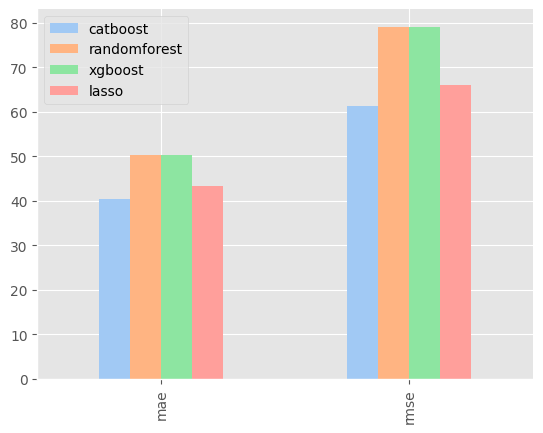

In [76]:
error_rec = {
    "catboost": {
        "mae": 40.31282314859388,
        "rmse": 61.2069236302688,
    },
    "randomforest": {
        "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "xgboost": {
         "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "lasso": {
         "mae": 43.26164501092259,
        "rmse": 66.08328222674918,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

# <span style="font-family:cursive;text-align:center">Hyperparameter Tuning</span>

### <span style="font-family:cursive;text-align:center">Using CrossValidation on CatBoost</span>

In [77]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 57.3788132	test: 59.7180916	best: 59.7180916 (0)	total: 509ms	remaining: 4m 13s
75:	learn: 44.5026004	test: 47.7490779	best: 47.7490779 (75)	total: 43.1s	remaining: 4m
150:	learn: 41.6651064	test: 45.7873206	best: 45.7873206 (150)	total: 1m 25s	remaining: 3m 17s
225:	learn: 40.4298832	test: 45.2037231	best: 45.2037231 (225)	total: 2m 7s	remaining: 2m 35s
300:	learn: 39.6033081	test: 44.9221590	best: 44.9221590 (300)	total: 2m 50s	remaining: 1m 52s
375:	learn: 38.9818240	test: 44.7508335	best: 44.7508335 (375)	total: 3m 31s	remaining: 1m 9s
450:	learn: 38.3677766	test: 44.5557326	best: 44.5557326 (450)	total: 4m 13s	remaining: 27.5s
499:	learn: 37.9821162	test: 44.4628855	best: 44.4628855 (499)	total: 4m 41s	remaining: 0us

bestTest = 44.46288545
bestIteration = 499



1it [04:42, 282.01s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.668049597439698


0:	learn: 57.9485518	test: 57.4149150	best: 57.4149150 (0)	total: 508ms	remaining: 4m 13s
75:	learn: 44.8410869	test: 45.7855691	best: 45.7855691 (75)	total: 42.3s	remaining: 3m 56s
150:	learn: 41.8578167	test: 44.0869175	best: 44.0869175 (150)	total: 1m 24s	remaining: 3m 14s
225:	learn: 40.5244739	test: 43.5839453	best: 43.5839453 (225)	total: 2m 5s	remaining: 2m 32s
300:	learn: 39.5759758	test: 43.3837819	best: 43.3837819 (300)	total: 2m 47s	remaining: 1m 50s
375:	learn: 38.8918057	test: 43.2839987	best: 43.2817322 (372)	total: 3m 28s	remaining: 1m 8s
450:	learn: 38.1973204	test: 43.1734986	best: 43.1734986 (450)	total: 4m 10s	remaining: 27.2s
499:	learn: 37.7940865	test: 43.1442088	best: 43.1434507 (495)	total: 4m 37s	remaining: 0us

bestTest = 43.14345067
bestIteration = 495

Shrink model to first 496 iterations.


2it [09:19, 279.61s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.568367415253983


0:	learn: 58.0011159	test: 57.2305237	best: 57.2305237 (0)	total: 647ms	remaining: 5m 22s
75:	learn: 45.0276727	test: 45.5473263	best: 45.5473263 (75)	total: 42.8s	remaining: 3m 58s
150:	learn: 42.0915822	test: 43.7779717	best: 43.7779717 (150)	total: 1m 25s	remaining: 3m 17s
225:	learn: 40.7359022	test: 43.2580538	best: 43.2580538 (225)	total: 2m 8s	remaining: 2m 35s
300:	learn: 39.7829721	test: 43.0082336	best: 43.0082336 (300)	total: 3m 10s	remaining: 2m 5s
375:	learn: 39.0137915	test: 42.8203620	best: 42.8203620 (375)	total: 4m 4s	remaining: 1m 20s
450:	learn: 38.3575646	test: 42.6949268	best: 42.6949268 (450)	total: 5m 12s	remaining: 33.9s
499:	learn: 37.9217101	test: 42.6057647	best: 42.6038099 (498)	total: 5m 45s	remaining: 0us

bestTest = 42.60380987
bestIteration = 498

Shrink model to first 499 iterations.


3it [15:06, 310.20s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.5271594084169084


0:	learn: 57.8885293	test: 57.6813179	best: 57.6813179 (0)	total: 498ms	remaining: 4m 8s
75:	learn: 44.7020030	test: 46.0922428	best: 46.0922428 (75)	total: 43.4s	remaining: 4m 2s
150:	learn: 41.7142135	test: 44.4560034	best: 44.4560034 (150)	total: 1m 25s	remaining: 3m 18s
225:	learn: 40.3536892	test: 43.9652190	best: 43.9652190 (225)	total: 2m 6s	remaining: 2m 33s
300:	learn: 39.4490066	test: 43.7716459	best: 43.7716459 (300)	total: 2m 49s	remaining: 1m 52s
375:	learn: 38.7896620	test: 43.6558391	best: 43.6558391 (375)	total: 3m 31s	remaining: 1m 9s
450:	learn: 38.1732004	test: 43.5555562	best: 43.5555562 (450)	total: 4m 12s	remaining: 27.4s
499:	learn: 37.8134916	test: 43.5080537	best: 43.5056759 (496)	total: 4m 38s	remaining: 0us

bestTest = 43.50567588
bestIteration = 496

Shrink model to first 497 iterations.


4it [19:45, 298.02s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.595883251579239


0:	learn: 58.0235318	test: 57.2308979	best: 57.2308979 (0)	total: 522ms	remaining: 4m 20s
75:	learn: 44.9747539	test: 45.5325364	best: 45.5325364 (75)	total: 43s	remaining: 3m 59s
150:	learn: 41.9892313	test: 43.7670710	best: 43.7670710 (150)	total: 1m 25s	remaining: 3m 17s
225:	learn: 40.5880815	test: 43.2787637	best: 43.2787637 (225)	total: 2m 7s	remaining: 2m 34s
300:	learn: 39.6359910	test: 43.0870658	best: 43.0870658 (300)	total: 2m 50s	remaining: 1m 52s
375:	learn: 38.9313150	test: 42.9660786	best: 42.9660786 (375)	total: 3m 32s	remaining: 1m 10s
450:	learn: 38.3605027	test: 42.8859130	best: 42.8839767 (447)	total: 4m 14s	remaining: 27.6s
499:	learn: 37.9304102	test: 42.8283531	best: 42.8283531 (499)	total: 4m 41s	remaining: 0us

bestTest = 42.82835308
bestIteration = 499



5it [24:28, 293.70s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.544337487538019


### <span style="font-family:cursive;text-align:center">Using Optuna with Random Forest</span> 

In [78]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()



In [79]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [80]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2023-05-02 13:13:50,535] A new study created in memory with name: no-name-c558910b-f1d9-4e2e-a7b5-666ebd2f282d
[I 2023-05-02 13:23:08,950] Trial 0 finished with value: -45.31773443061755 and parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 0.6975182863821788}. Best is trial 0 with value: -45.31773443061755.


Best score: -45.31773443061755
Optimized parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 0.6975182863821788}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: user 9min 5s, sys: 773 ms, total: 9min 6s
Wall time: 9min 18s


In [81]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.6975182863821788,
                      min_samples_split=8, n_estimators=187)

### <span style="font-family:cursive;text-align:center">Final Evaluation</span>

Text(0.5, 0, 'iteration')

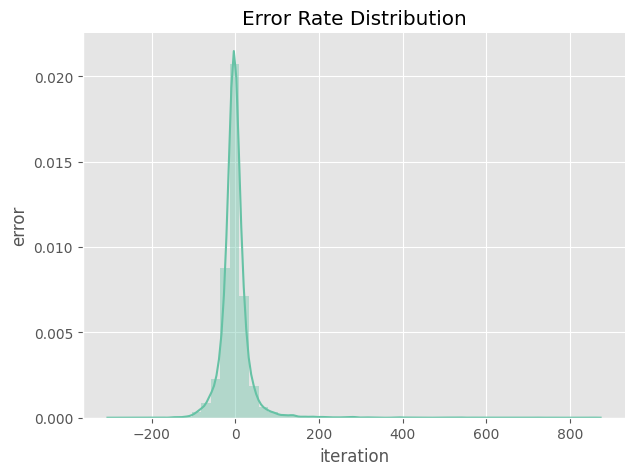

In [82]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

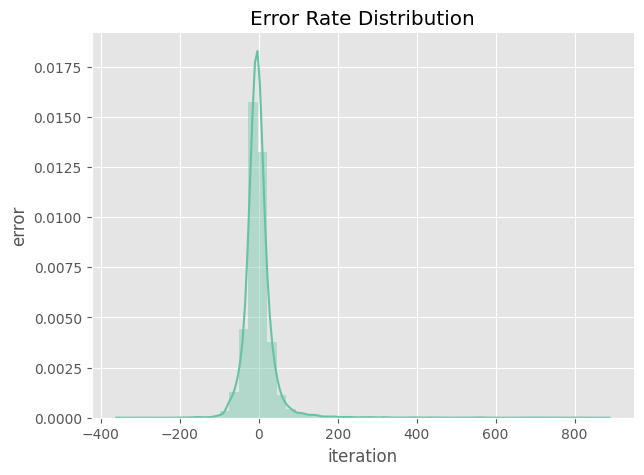

In [83]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### <span style="font-family:cursive;text-align:center">Saving Models</span>

In [84]:
with open('rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [85]:
## Load models here
load = False
if load:
    with open('rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

# <span style="font-family:cursive;text-align:center">Explainable AI</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 

we will extract new weather statistics from the building location weather featurespick your sample to study the model upon

In [86]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(size)
sample_set

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
15679          1.0    103201.0      1956.0           64.857143       42.7   
22842          2.0     94080.0      1930.0           65.142857       42.7   
68762          6.0     90000.0      1986.0           81.000000        3.0   
12511          6.0     59310.0      1950.0           36.000000      198.1   
74892          6.0     69492.0      1987.0          100.000000       26.5   
...            ...         ...         ...                 ...        ...   
18788          2.0     63121.0      1941.0           43.142857       42.7   
28000          3.0    210070.0      1924.0           85.000000       15.2   
30040          3.0     77800.0      1925.0           60.428571       15.2   
51571          5.0     67422.0      1941.0           71.000000       15.2   
54381          6.0     93261.0      1953.0           52.000000        3.4   

       january_min_temp  january_avg_temp  january_max_temp  \
15679               6.0         29.677419              53.0   
22842              13.0         37.322581              62.0   
68762               8.0         29.827586              62.0   
12511              -2.0         25.166667              50.0   
74892              28.0         43.451613              56.0   
...                 ...               ...               ...   
18788              13.0         37.322581              62.0   
28000              11.0         35.080645              61.0   
30040              11.0         35.080645              61.0   
51571               8.0         29.854839              56.0   
54381              11.0         34.451613              59.0   

       february_min_temp  february_avg_temp  february_max_temp  \
15679               15.0          36.035714               67.0   
22842               20.0          40.879310               62.0   
68762                4.0          33.896552               62.0   
12511                2.0          29.711538               65.0   
74892               34.0          47.672414               64.0   
...                  ...                ...                ...   
18788               20.0          40.879310               62.0   
28000               17.0          33.910714               55.0   
30040               17.0          33.910714               55.0   
51571                2.0          23.946429               43.0   
54381               -1.0          37.706897               61.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
15679            20.0       42.322581            77.0            35.0   
22842            25.0       50.935484            78.0            38.0   
68762            24.0       45.967742            79.0            18.0   
12511            12.0       44.516129            73.0            23.0   
74892            35.0       49.354839            71.0            40.0   
...               ...             ...             ...             ...   
18788            25.0       50.935484            78.0            38.0   
28000            27.0       40.145161            59.0            33.0   
30040            27.0       40.145161            59.0            33.0   
51571            12.0       38.096774            62.0            32.0   
54381            26.0       48.870968            79.0            26.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
15679       54.300000            83.0          46.0     64.483871   
22842       54.766667            88.0          49.0     65.096774   
68762       49.931034            81.0          37.0     59.161290   
12511       49.017241            88.0          38.0     61.933333   
74892       56.266667            89.0          45.0     59.193548   
...               ...             ...           ...           ...   
18788       54.766667            88.0          49.0     65.096774   
28000       52.983333            82.0          42.0     62.790323   
30040       52.983333            8

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> calculate shap values

In [87]:
is_saved = False

if is_saved:
    with open('data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(rf).shap_values(sample_set)

In [88]:
shap.initjs()

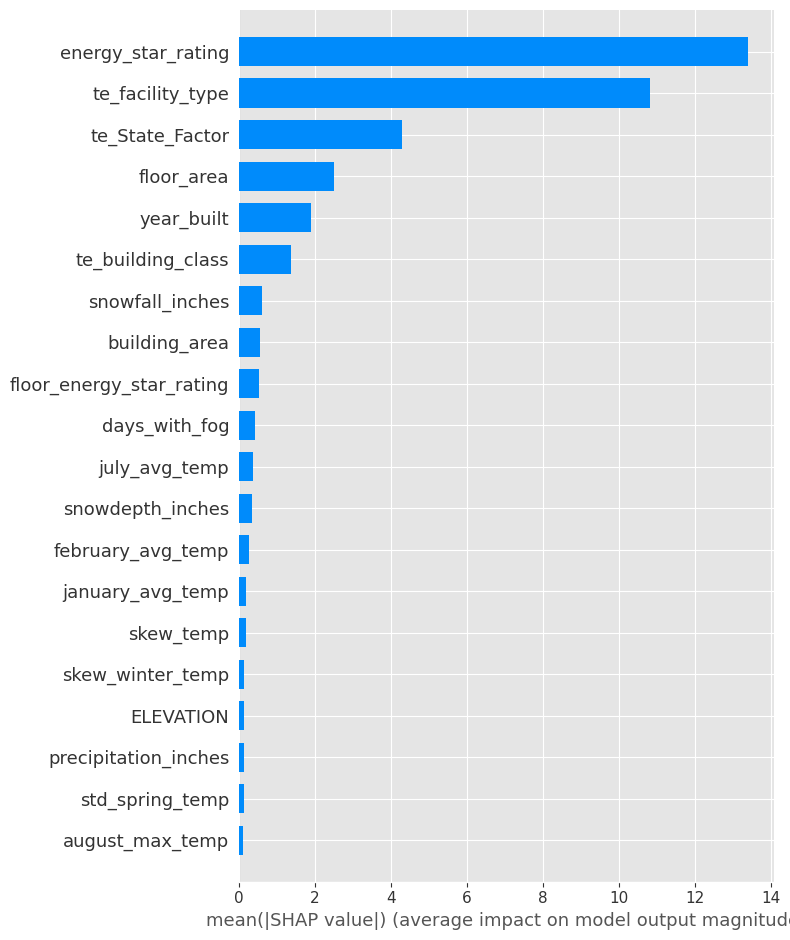

In [89]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

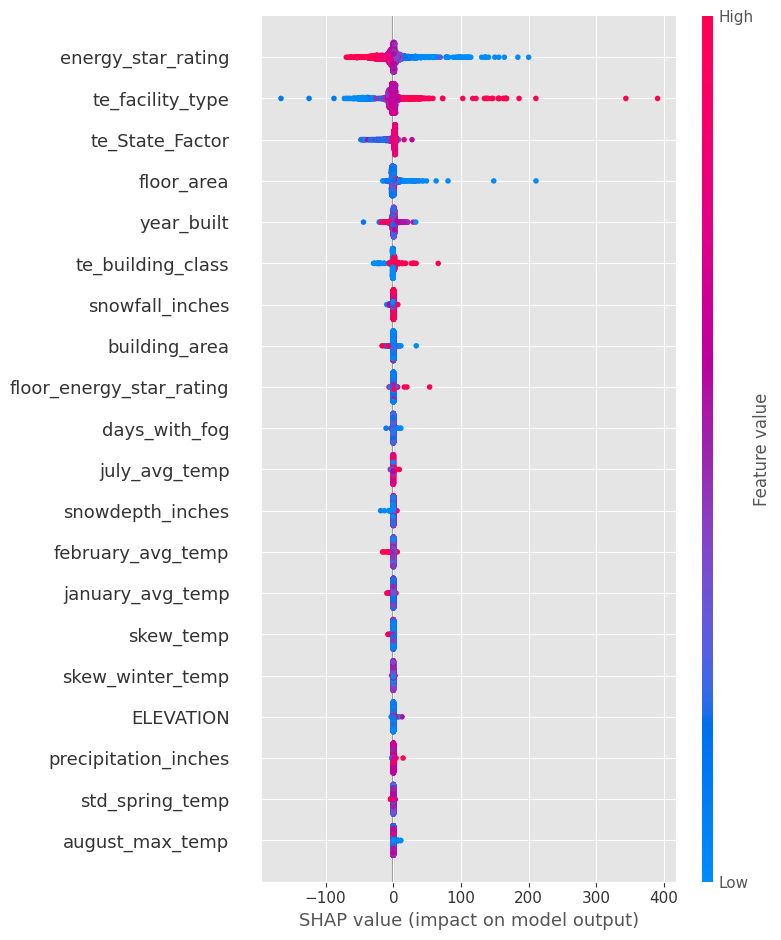

In [90]:
shap.summary_plot(shap_values, sample_set)

In [91]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [92]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

211.92779349436714


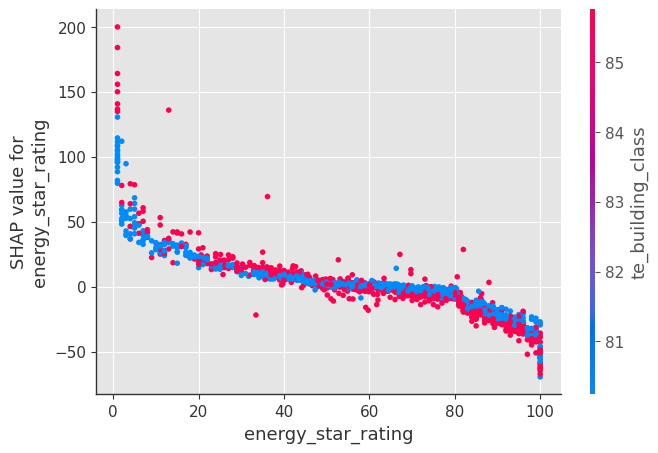

In [93]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

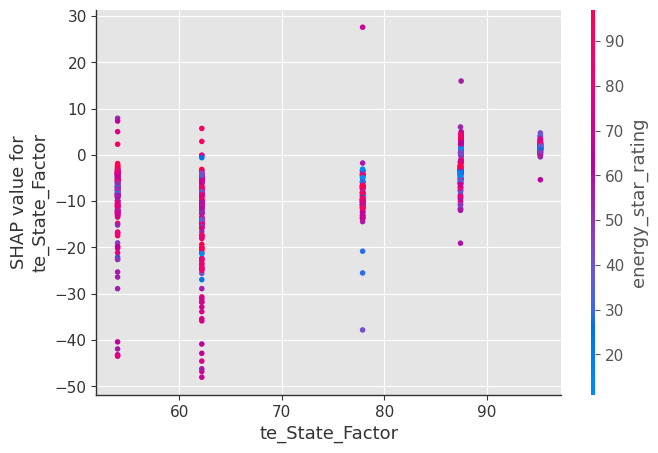

In [94]:
shap.dependence_plot('te_State_Factor', shap_values, sample_set)

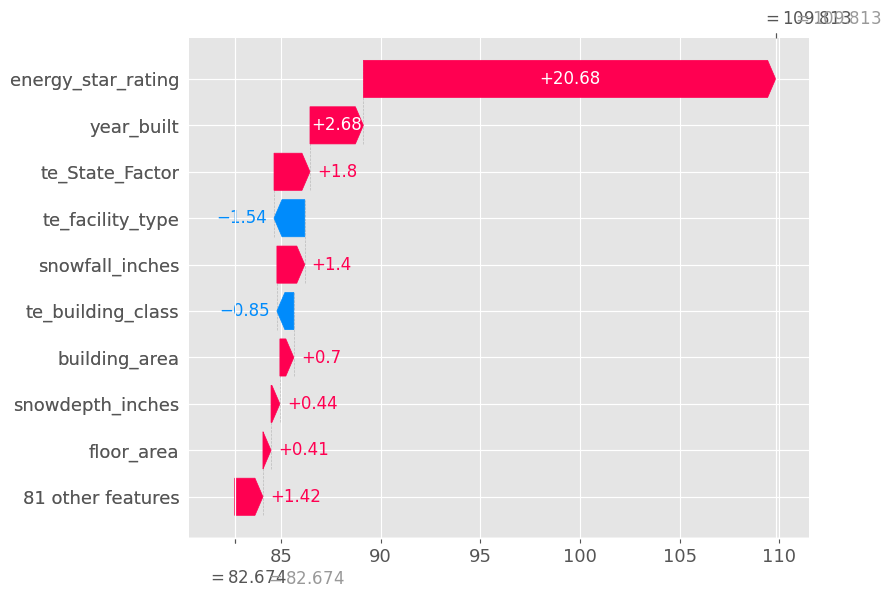

In [95]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

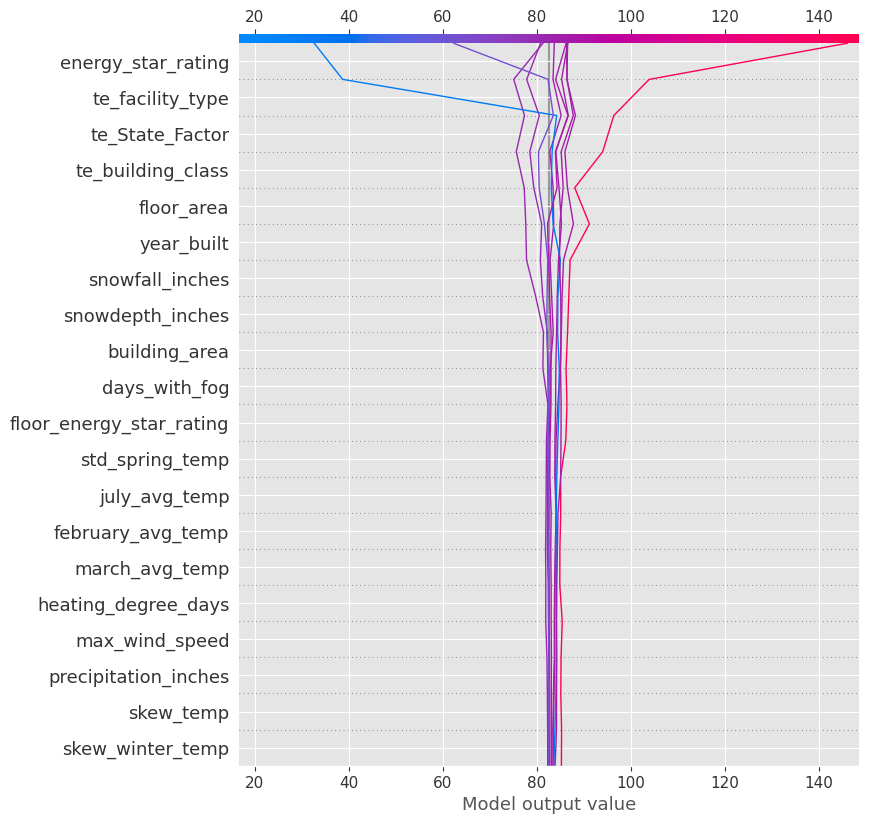

In [96]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

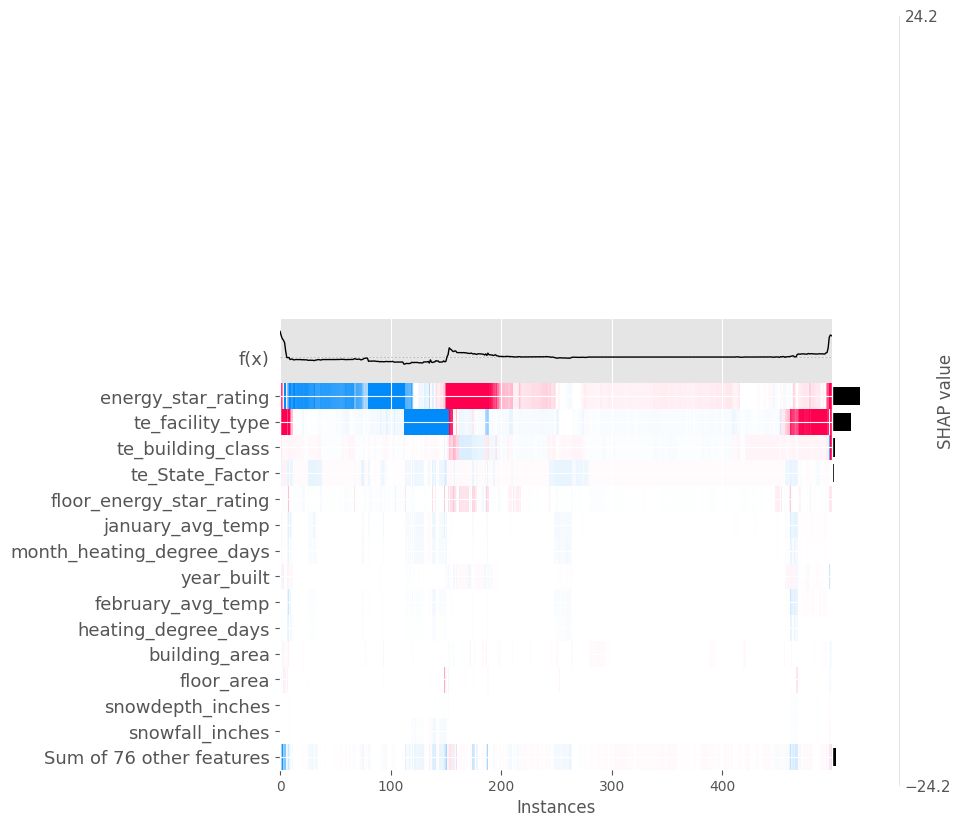

In [97]:
limit = 500
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)

In [99]:
pip freeze > requirements.txt